In [2]:
from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk, load
import numpy as np
import skimage.transform

from MedT_C import MedT_C

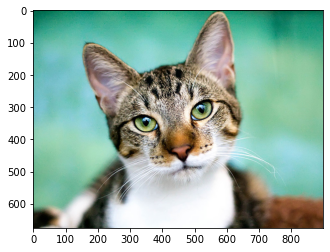

In [65]:
image = Image.open("./data/single-images/cat2.jpg")
imshow(image)

In [66]:
# preprocess to correct size and normalisation for CIFAR dataset

preprocess = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

display_transform = transforms.Compose([
    transforms.Resize((32,32))
])

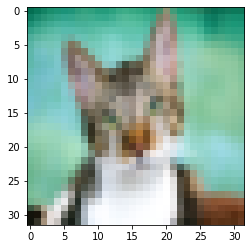

In [67]:
imshow(display_transform(image))

In [68]:
tensor = preprocess(image)

In [69]:
prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad=True)

In [70]:
model = MedT_C()
model.load_state_dict(load("./outputs/model.pth"))
model.cuda()

MedT_C(
  (global_branch): Encoder(
    (cnn): Sequential(
      (0): Conv2d(3, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (transformer): ModuleList(
      (0): GatedAxialTransformerLayer(
        (conv_down): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (height_attention): AxialAttention(
          (to_qvk): Sequential(
            (0): Conv1d(128, 256, kernel_size=(1,), stride=(1,), bias=False)
            (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (RelativePosEncQKV): Relative2DPosEncQKV()
          (attention_norm): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (out_norm): BatchNorm1d(256, eps=1e-05, momentum=0.

In [71]:
class SaveFeatures():
    features = None

    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()

    def remove(self):
        self.hook.remove()

In [72]:
final_layer = model._modules.get('global_branch')

In [73]:
activated_features = SaveFeatures(final_layer)

In [74]:
prediction = model(prediction_var)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()

<ipython-input-74-5893ac2c4294>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities = F.softmax(prediction).data.squeeze()


In [75]:
topk(pred_probabilities, 1)

torch.return_types.topk(
values=tensor([0.3058], device='cuda:0'),
indices=tensor([3], device='cuda:0'))

In [76]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [77]:
weight_softmax_params = list(model.decoder._modules.get('decoder').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [78]:
weight_softmax_params

[Parameter containing:
 tensor([[ 3.7256e-02,  8.8333e-02,  2.2725e-01,  ...,  7.8860e-02,
          -5.4710e-02, -3.3479e-02],
         [ 4.5162e-02, -1.7091e-01, -1.8408e-02,  ..., -1.5237e-01,
          -1.2714e-01,  2.7608e-01],
         [ 2.1483e-01,  3.6596e-02, -3.2821e-02,  ..., -8.1723e-02,
           4.2598e-02, -1.2371e-01],
         ...,
         [-1.2762e-01, -1.6239e-03,  4.8511e-03,  ...,  2.6520e-02,
           6.7171e-03, -8.5052e-02],
         [-1.7089e-01,  3.2766e-01,  6.2010e-02,  ..., -2.8080e-02,
           5.0811e-02,  1.0140e-01],
         [-4.3639e-02,  1.3672e-02,  2.2539e-01,  ...,  5.1485e-02,
          -1.7922e-01, -1.1153e-04]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.0240, -0.0615,  0.0508,  0.0328,  0.0712, -0.0003, -0.0488,  0.0337,
          0.0508, -0.0161], device='cuda:0', requires_grad=True)]

In [79]:
class_idx = topk(pred_probabilities, 1)[1].int()

In [80]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx)

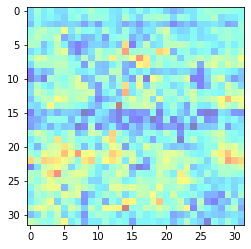

In [81]:
imshow(overlay[0], alpha=0.5, cmap='jet')

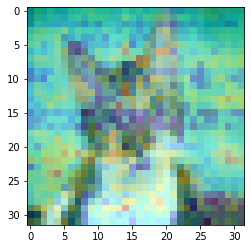

In [82]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.3, cmap='jet')